<a href="https://colab.research.google.com/github/jessie-dotson/my-tutorials/blob/master/Collab%20Lightkurve%20at%20TASC%20KASC%20July%202019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Lightkurve

Lightkurve is an open source python tool for investigating Kepler, K2, and TESS data.  The available functionality includes:

1. Searching for Kepler, K2 and TESS data at MAST.stsci.edu
2. Downloading target pixel files and lightcurve files from MAST.stsci.edu
3. Investigating and definining custom apertures
4. Creating a bespoke lightcurve
5. Correcting lightcurves
6. Removing systematics from lightcurves
7. Exporting your lightcurves to other formats

And lots more...  I'll touch on these topics (at warp speed).  Oliver Hall will present astereoseismology with lightkurve in the next talk.

You can learn more and find loads more tutorials at https://keplerscience.arc.nasa.gov/software.html and https://docs.lightkurve.org/


*The first cell is only needed if you're running the notebook on Google Colab*

In [0]:
! pip install lightkurve 

If you're running on your laptop, start here...

In [0]:
import lightkurve as lk

## 1. Searching for data

Lightkurve provides several search functions which allow you to query MAST.stsci.edu for target pixel files, lightcurves and TESS cut-outs.  Targets can be specified by KIC id, EPIC id, TIC id, target name, or RA/Dec.

EPIC 205901703 is a 8.2 KepMag red giant star observed by both TESS and K2.

Target pixel files are a time series of images containing a cut out of pixels around the target.  Let's start by seeing what target pixel files are avaialble...

In [0]:
mytarget = "EPIC 205901703"

tpf_list = lk.search_targetpixelfile(mytarget)

tpf_list

SearchResult containing 2 data products.

 target_name                      productFilename                                  description              distance
------------- ------------------------------------------------------- ------------------------------------- --------
ktwo205901703                      ktwo205901703-c03_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C03      0.0
     69763457 tess2018234235059-s0002-0000000069763457-0121-s_tp.fits                    Target pixel files      0.0

Great!  It's got K2 long cadence and TESS 2-minute cadence target pixel files.  But let's go ahead and look for 30 minute data via the TESS cut service.

In [0]:
tesscut_list = lk.search_tesscut(mytarget)
tesscut_list

SearchResult containing 1 data products.

 target_name   productFilename        description         distance
-------------- --------------- -------------------------- --------
EPIC 205901703             n/a TESS FFI Cutout (sector 2)      0.0

And finally -- let's look to see what lightcurves are available...

In [0]:
lc_list = lk.search_lightcurvefile(mytarget)

lc_list

SearchResult containing 2 data products.

 target_name                      productFilename                                 description             distance
------------- ------------------------------------------------------- ----------------------------------- --------
ktwo205901703                              ktwo205901703-c03_llc.fits Lightcurve Long Cadence (KLC) - C03      0.0
     69763457 tess2018234235059-s0002-0000000069763457-0121-s_lc.fits                        Light curves      0.0

## 2. Downloading data

Now that we know what data's available, let's download a target pixel file and load it into lightkurve. Downloading is a method that applies to lightkurve search results.  

In [0]:
k2_tpf = tpf_list[0].download()
tess_tpf = tpf_list[1].download()

It's also possible to string together the searching and downloading steps into a single command.  The command below yields identical results!

`k2_tpf = lk.search_targetpixelfile(mytarget, mission="K2").download()`

Before moving on, let's investigate this target pixel file object a bit...

What does it look like?

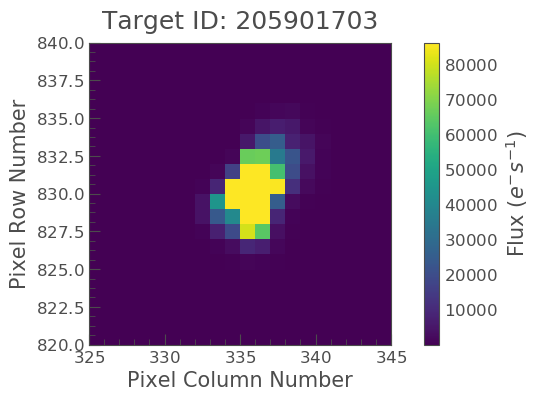

In [0]:
%matplotlib inline 
k2_tpf.plot()


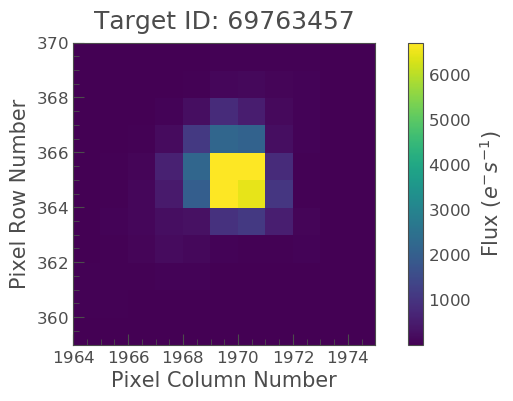

In [0]:
tess_tpf.plot()

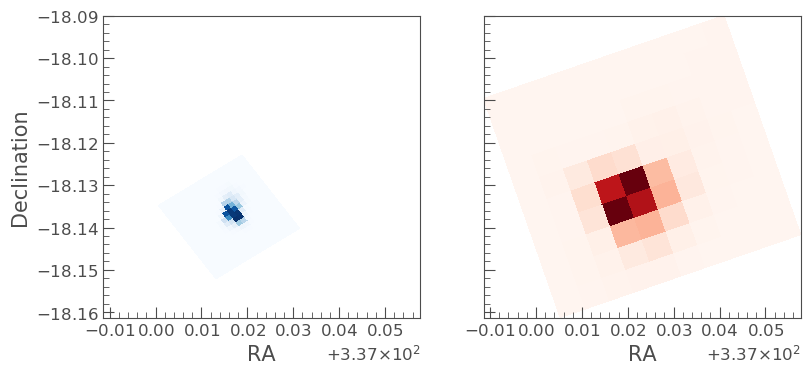

In [0]:
import matplotlib.pyplot as plt
with plt.style.context(lk.MPLSTYLE):
    _, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
    ax[0].pcolormesh(*k2_tpf.get_coordinates(0), k2_tpf.flux[0], cmap='Blues')
    ax[1].pcolormesh(*tess_tpf.get_coordinates(0), tess_tpf.flux[0], cmap='Reds')

    ax[0].set_xlabel("RA")
    ax[1].set_xlabel("RA")
    ax[0].set_ylabel("Declination")

How big are the images?

In [0]:
k2_tpf.flux.shape

(3192, 20, 20)

In [0]:
tess_tpf.flux.shape

(18317, 11, 11)

Which make sense...  The K2 data is 30minute cadence for ~ 80 days.  TESS is 2 minute cadence for 27 days.


What do the timestamps look like?  

In [0]:
k2_tpf.time

array([2144.1029802 , 2144.12341256, 2144.14384471, ..., 2213.22352569,
       2213.24395735, 2213.26438901])

The Kepler/K2 time stamps are Kepler-specific Barycentric Kepler Julian Day format (BKJD).  You can convert it into an astropy time object (http://docs.astropy.org/en/stable/time/)

In [0]:
k2_tpf.astropy_time

<Time object: scale='tdb' format='jd' value=[2456977.1029802  2456977.12341256 2456977.14384471 ... 2457046.22352569
 2457046.24395735 2457046.26438901]>

Let's take a quick look and see if there are any nearby stars we need to worry about...

*Unfortunately, this won't work in Google Colab because it depends on bokeh*

In [0]:
k2_tpf.interact_sky()

So, there is another star in the neighborhood, but it's so much fainter, it won't cause a problem.

The TESS aperture covers a much bigger section of the sky -- so let's check that one out too...

*Unfortunately, this won't work in Google Colab because it depends on bokeh*

In [0]:
tess_tpf.interact_sky()

More neighbors, but again -- they're faint, so no worries here!

## 3. Investigating and Defining Custom Apertures

Overall, the Kepler, K2, and TESS pipelines do an excellent job choosing a aperture mask.  But often a bespoke aperture can be better for a specific source.  Let's start out by looking at the pipeline aperture...

The boolean array representing the pipeline mask can be accessed as k2_tpf.pipeline_mask.  This one is kind of big, so let's just plot it...

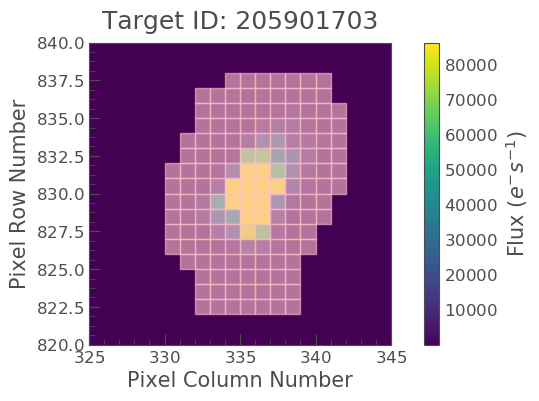

In [0]:
k2_tpf.plot(aperture_mask=k2_tpf.pipeline_mask)

Lightkurve provides 3 ways to define a custom mask:
* a manually defined boolean array 
* a treshold mask 
* interactively

The mask made by create_threshold_mask consists of pixels whose median flux is 3x larger than the standard deviation of the overall median.  The default ratio is 3, but you can specify other threshold ratios if you like.

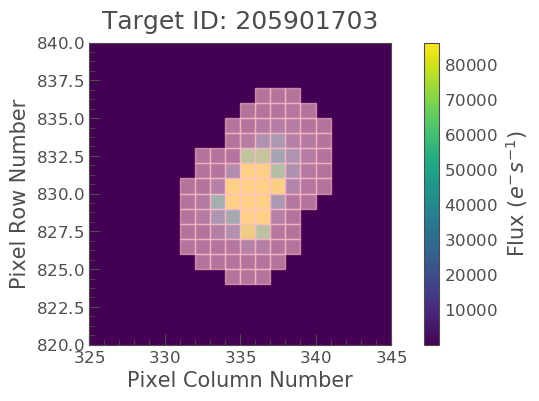

In [0]:
k2_threshold_mask = k2_tpf.create_threshold_mask(threshold=4)

k2_tpf.plot(aperture_mask = k2_threshold_mask)

Lightkurve's interact functionality makes it easy to check out any image that corresponds to a time step and investigate alternate apertures. 

By pointing and clicking on the image, you can define your own aperture mask.  You can select and drag to create rectangular apertures.  Holding down the shift key while you click will let you add/subtract individual pixels.  The displayed lightcurve is recalculated according to the selected pixels.

*Unfortunately interact won't work on Google Colab since it relies on bokeh.*

In [0]:
k2_tpf.interact()


If you create a lightcurve interactively that you want to keep, just use the *Save Lightcurve* button to save the lightcurve in a fits file.

Your new lightcurve can be read in as a LightCurve object, just like you would for any of the pipeline products. 

In [0]:
# this cell will read in a locally saved file (but won't work in colab)
k2_interact_lcf = lk.open("ktwo205901703-c03_lpd-targ-custom-lc.fits")


In [0]:
# for google colab; will read in a pre-saved custom lightcurve
fileurl="https://github.com/jessie-dotson/my-tutorials/blob/master/ktwo205901703-c03_lpd-targ-custom-lc.fits?raw=true"

k2_interact_lcf=lk.open(fileurl)

And your custom aperture mask is there in the HDU waiting for you!

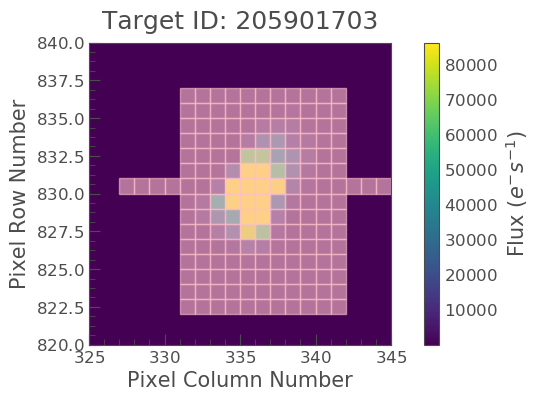

In [0]:
k2_custom_mask = k2_interact_lcf.hdu['APERTURE'].data > 1
k2_tpf.plot(aperture_mask=k2_custom_mask)

Let's also look at the TESS pipeline aperture and try a couple alternative aperatures.

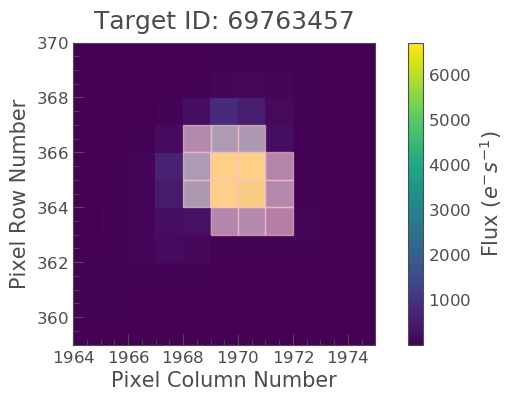

In [0]:
tess_tpf.plot(aperture_mask=tess_tpf.pipeline_mask)

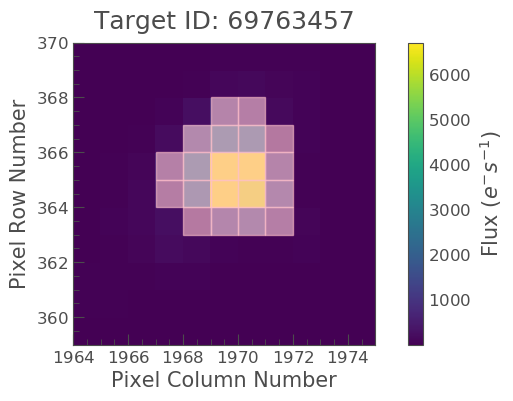

In [0]:
tess_threshold_mask = tess_tpf.create_threshold_mask(threshold=5)

tess_tpf.plot(aperture_mask = tess_threshold_mask)

In [0]:
tess_tpf.interact()

Again, we can read the custom lightcurve back in for future use...

In [0]:
# this cell will read in a locally stored file, but won't work in google colab
tess_interact_lcf = lk.open("tess2018234235059-s0002-0000000069763457-0121-s_tp-custom-lc.fits")

In [0]:
# for google colab; will read in a pre-saved custom lightcurve
fileurl="https://github.com/jessie-dotson/my-tutorials/blob/master/tess2018234235059-s0002-0000000069763457-0121-s_tp-custom-lc.fits?raw=true"

tess_interact_lcf=lk.open(fileurl)

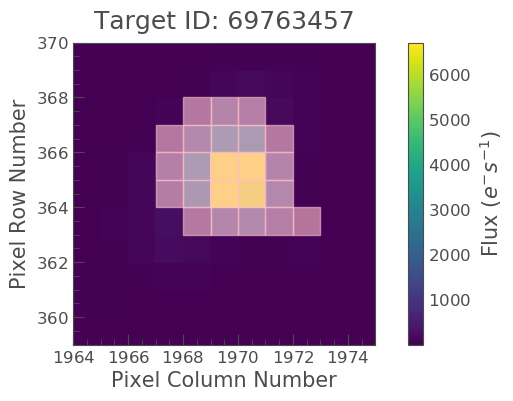

In [0]:

tess_custom_mask = tess_interact_lcf.hdu['APERTURE'].data > 1
tess_tpf.plot(aperture_mask=tess_custom_mask)

## 4. Creating a Lightcurve

Lightkurve can generate a lightcurve from a target pixel file via aperture photometry or prf photometry.   Today, we're going to stick with aperture photometry.  (More info about using lightkurve for prf photometry is available at https://docs.lightkurve.org/.)

Let's do one last check before moving onto creating a lightcurve though -- let's check that there's nothing funky going on in the default background...

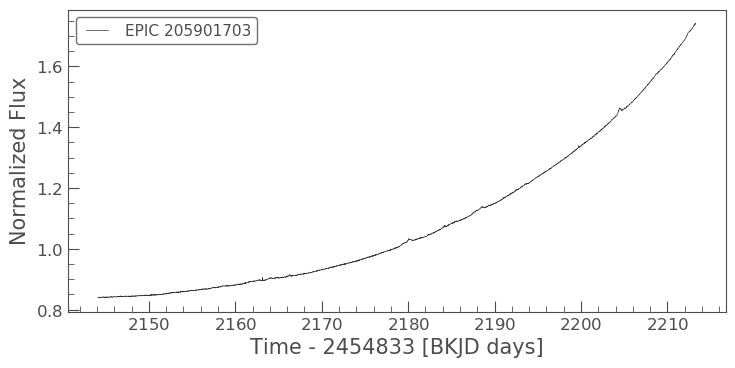

In [0]:
temp = k2_tpf.get_bkg_lightcurve()
temp.plot()

So, nothing of concern in the K2 background...

TESS background has some heavy lifting to do, so let's check those out also.

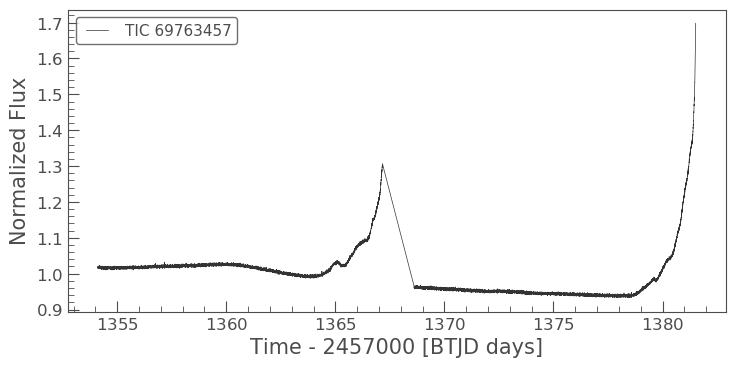

In [0]:
temp = tess_tpf.get_bkg_lightcurve()
temp.plot()


After section #3, we have several different apertures we can try out...  So let's try them all and compare!

First off, let's use the pipeline mask.

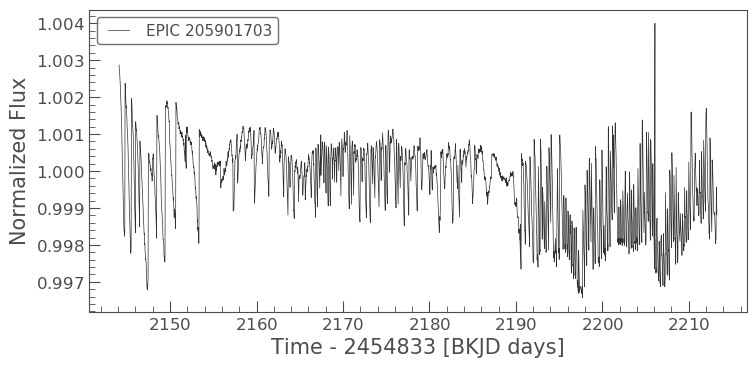

In [0]:
k2_lc = k2_tpf.to_lightcurve()

k2_lc.plot()

And now the threshold mask...

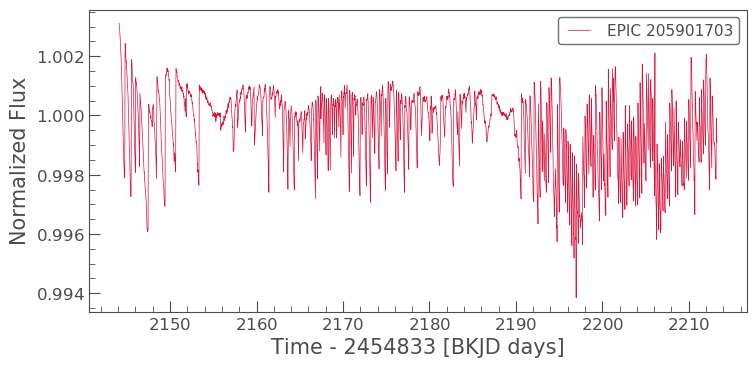

In [0]:
k2_threshold_lc = k2_tpf.to_lightcurve(aperture_mask=k2_threshold_mask)

k2_threshold_lc.plot(color="crimson")

And finally, a lightcurve from the custom mask...

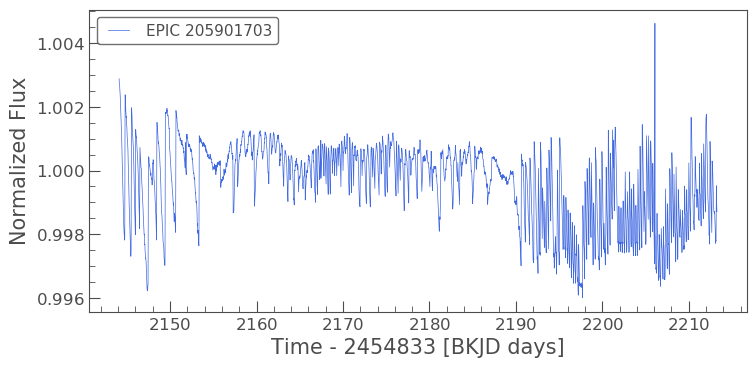

In [0]:
k2_custom_lc = k2_tpf.to_lightcurve(aperture_mask = k2_custom_mask)

k2_custom_lc.plot(color="royalblue")

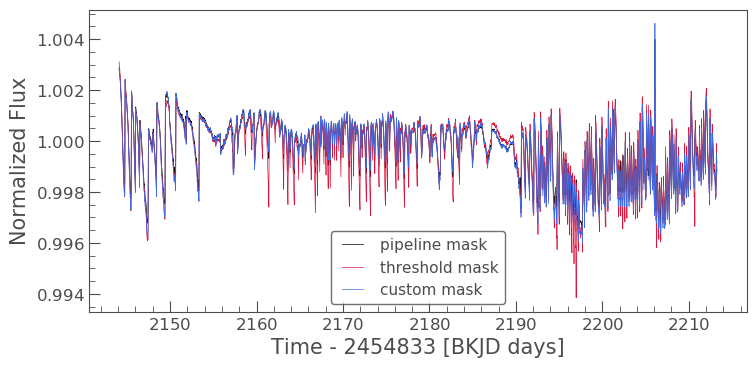

In [0]:
ax = k2_lc.plot(color="k",linestyle="-",label='pipeline mask')  #black
ax = k2_threshold_lc.plot(ax=ax,color="crimson",linestyle='-',label='threshold mask')  #blue
k2_custom_lc.plot(ax=ax,color="royalblue",linestyle="-",label='custom mask')  #red

Let's also take a look at TESS lightcurves using different apertures...

Again, starting with the pipeline mask

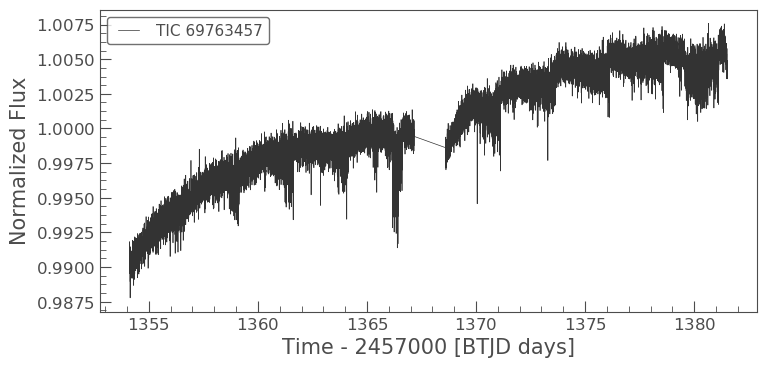

In [0]:
tess_lc = tess_tpf.to_lightcurve()

tess_lc.plot()

And now the threshold mask...

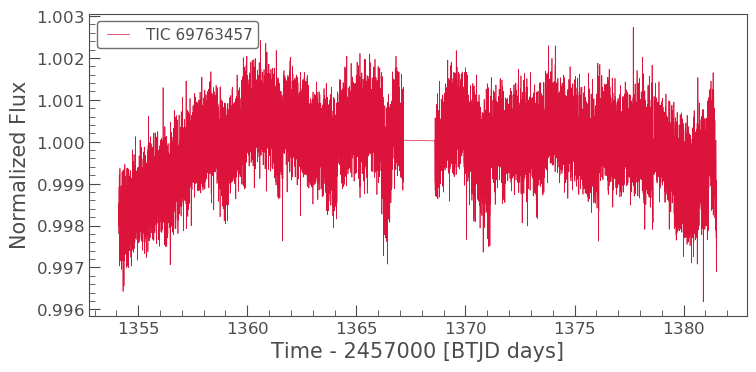

In [0]:
tess_threshold_lc = tess_tpf.to_lightcurve(aperture_mask=tess_threshold_mask)

tess_threshold_lc.plot(color="crimson")

And the custom mask too!

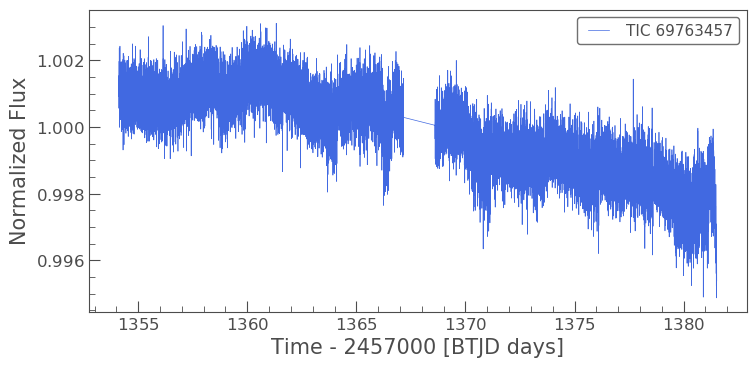

In [0]:
tess_custom_lc = tess_tpf.to_lightcurve(aperture_mask = tess_custom_mask)

tess_custom_lc.plot(color="royalblue")

Comparing the three different TESS lightcurves.

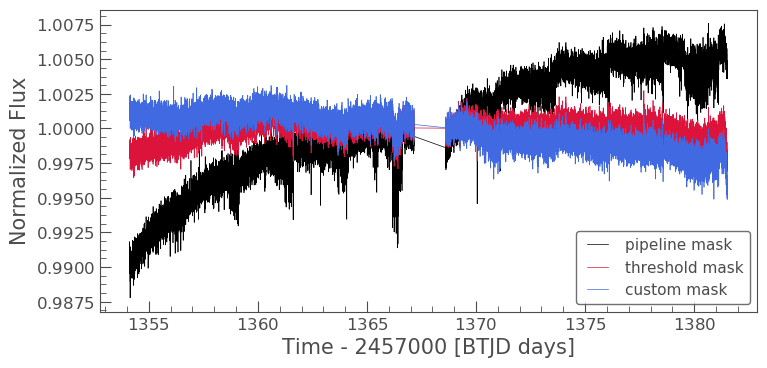

In [0]:
ax = tess_lc.plot(color="k",linestyle="-",label='pipeline mask')  #black
ax = tess_threshold_lc.plot(ax=ax,color="crimson",linestyle='-',label='threshold mask')  #blue
tess_custom_lc.plot(ax=ax,color="royalblue",linestyle="-",label='custom mask')  #red

## 5. Correcting lightcurves

Lightkurve makes it easy to do simple corrections to your lightcurve.  

* `lc.remove_nans()`
* `lc.remove_outliers()`
* `lc.normalize()`
* `lc.flatten()`
* `lc.bin()`

Applying any of these corrections to a lightcurve is trivial.  In the interst of time, I'm not going to step through all of them... 

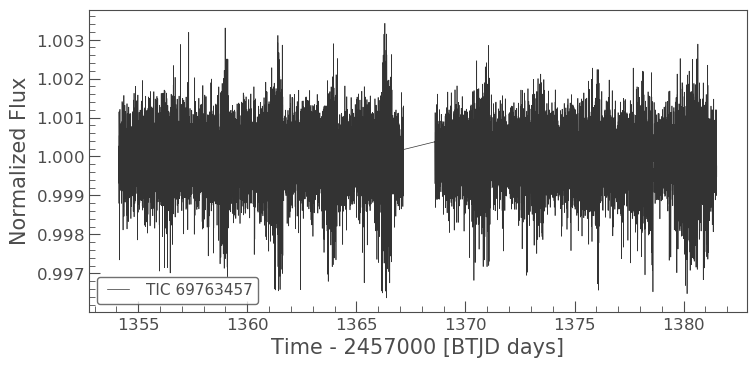

In [0]:
tess_lc = tess_lc.flatten().remove_nans().remove_outliers()
tess_lc.plot()

## 6. Removing systematics

There are several available approaches for removing systematics.  The pipeline lightcurve files include photometry corrected by the Presearch Data Conditioning algorithm.  Let's start by looking at that lightcurve...

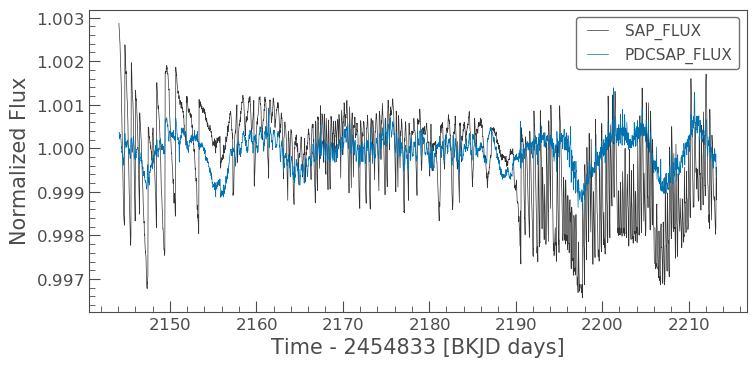

In [0]:
k2_pipeline_lcf = lk.search_lightcurvefile(mytarget, mission="K2").download()

k2_pipeline_lcf.plot()

The TESS pipeline also provides detrended lightcurves.

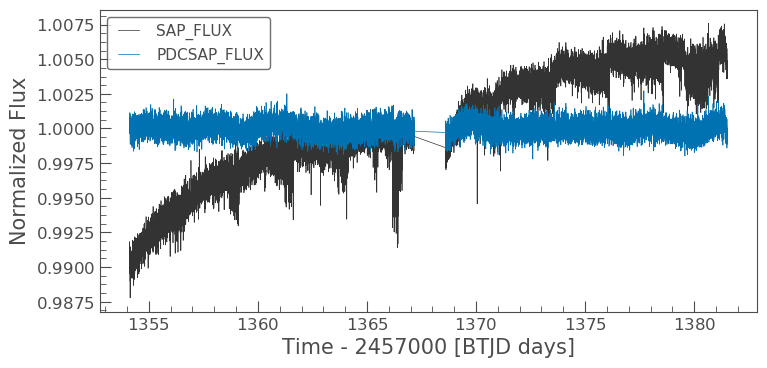

In [0]:
tess_pipeline_lcf = lk.search_lightcurvefile(mytarget, mission="TESS").download()

tess_pipeline_lcf.plot()

Lightkurve provides 3 ways to perform your own systematics correction.  
* cotrending basis vector correction (CBV)
* self-flat fielding (SFF)
* pixel level decorrelation (PLD)

We'll step through the first two methods here.  (If you want more info about the pixel level decorrelation method, come talk to us later!)

The cotrending basis vector correction via KeplerCBVCorrector utilizes a method similar to -- but not identical to the pipeline's PDC. It allows you to choose which of the pipeline determined CBVs you want to apply -- and lets you apply the CBV correction to a lightcurve with a maks you define. (A good place to learn more about CBV's is Demystifying Kepler Data at https://arxiv.org/pdf/1207.3093.pdf).

Let's first plot up the CBVs produced by the pipeline to see what they look like...

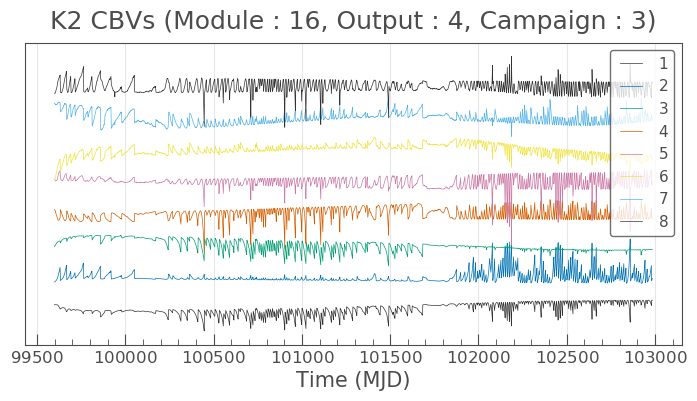

In [0]:
lk.KeplerCBVCorrector(k2_threshold_lc).plot_cbvs([1,2,3,4,5,6,7,8])

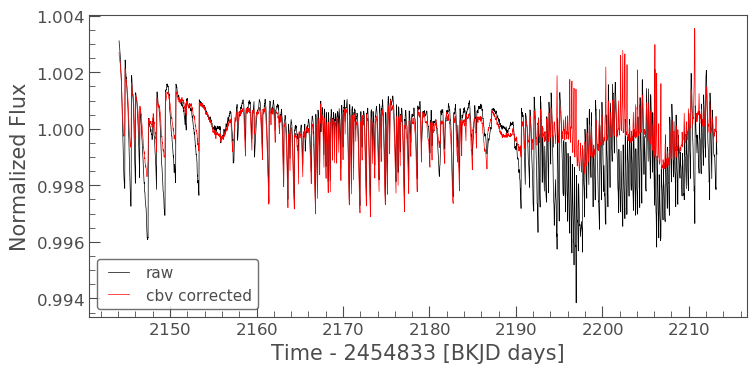

In [0]:
k2_threshold_lc_cbv = lk.KeplerCBVCorrector(k2_threshold_lc).correct()

ax=k2_threshold_lc.plot(color="k", label='raw',linestyle="-")
k2_threshold_lc_cbv.plot(ax=ax, label='cbv corrected', color="r", linestyle="-")

Let's also have a go at a self-flat fielding correction.  The lightkurve implementation of SFF is heavily based on Vanderburg & Jonson 2014 (https://arxiv.org/pdf/1408.3853.pdf).  There are several tuning parameters for the lightkurve sff correction.  

We can apply SFF to any lightcurve.  The pipeline's PDC is excellent at removing trends that are present across a detector while SFF is designed to remove trends due to the variations in intra- and inter- pixel sensitivity as your source moves.  These two can work well together...

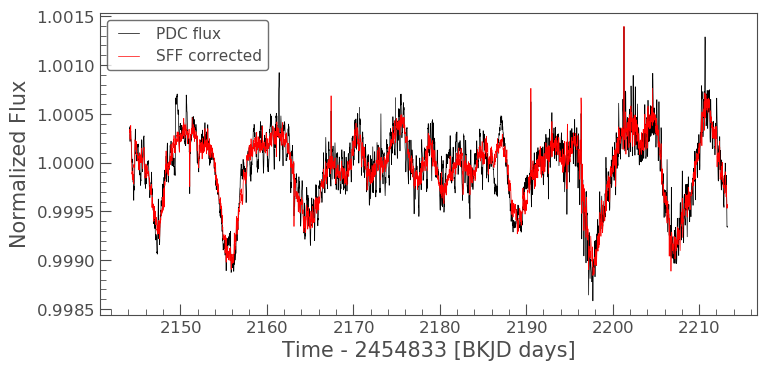

In [0]:
k2_pipeline_pdc_lc = k2_pipeline_lcf.PDCSAP_FLUX

k2_pdc_sff_lc = k2_pipeline_pdc_lc.to_corrector("sff").correct(restore_trend=True)

ax = k2_pipeline_pdc_lc.plot(color='k',label="PDC flux")
k2_pdc_sff_lc.plot(ax=ax,color="r",label="SFF corrected")

## 7. Exporting Lightcurves

Lightkurve includes functions for converting lightcurves to other formats (pandas, astropy table) and to write them to disk as either csv or fits files.

First let's convert our corrected lightcurve to pandas...

In [0]:
panda_lc = k2_pdc_sff_lc.to_pandas()


To an astropy table...

In [0]:
table_lc = k2_pdc_sff_lc.to_table()

Finally let's write it out in two different formats...

In [0]:
k2_pdc_sff_lc.to_fits("my_lightcurve.fits", overwrite="TRUE")

k2_pdc_sff_lc.to_csv("my_lightcurve.csv")

## Next Steps

Easy ways to learn more about lightkurve

1.  Oliver Hall's tutorial on astereoseismology with lightkuve (up next!)
2.  Check out Nick Saunder's poster
3.  Visit lightkurve.org
4.  Talk to Christina Hedges, Nicholas Saunders, Oliver Hall, or myself.
5.  Contribute at github.com/KeplerGO/lightkurve
